# Multi-Label Deep Learning Model for Planet Understanding Amazon from Space Using TensorFlow Take 4
### David Lowe
### November 6, 2020

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. [https://machinelearningmastery.com/]

SUMMARY: The purpose of this project is to construct a predictive model using various machine learning algorithms and to document the end-to-end steps using a template. The Planet: Understanding the Amazon from Space dataset is a multi-label classification situation where we are trying to predict one of several (more than two) possible outcomes.

INTRODUCTION: Planet, designer and builder of the world’s largest constellation of Earth-imaging satellites collaborated with its Brazilian partner SCCON in challenging Kaggle participants to label satellite image chips with atmospheric conditions and various classes of land cover/land use. The resulting models will help the global community better understand deforestation conditions and how to respond to them.

The purpose of this modeling exercise is to construct an end-to-end template for solving multi-label machine learning problems. The series of scripting exercises will replicate Dr. Jason Brownlee's blog post https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-to-classify-satellite-photos-of-the-amazon-rainforest/ on this topic to build a robust template for future similar problems.

From iteration Take1, we constructed the necessary script segments to download and pre-process the image files available on Kaggle’s website.

From iteration Take2, we constructed the necessary script segments to train the TensorFlow model and evaluated the model's effectiveness.

From iteration Take3, we constructed the necessary script segments to load an unseen image and perform prediction on the image.

In this Take4 iteration, we will construct the necessary script segments to load a list of test images from Kaggle and perform prediction on these images.

ANALYSIS: From iteration Take1, we successfully downloaded and pre-processed the image files from Kaggle.

From iteration Take2, the performance of the baseline model achieved a fbeta score of 0.8478 after 20 epochs using the validation dataset.

From iteration Take3, we successfully downloaded an image and made a prediction on the previously unseen photo.

In this Take4 iteration, we successfully processed the test images downloaded from Kaggle and made predictions on the previously unseen photos. We obtained a fbeta score of 0.6097 from our predictions.

CONCLUSION: In this iteration, the TensorFlow model appeared to be suitable for modeling this dataset. We should consider experimenting with TensorFlow for further modeling.

Dataset Used: Planet: Understanding the Amazon from Space

Dataset ML Model: Multi-label classification with numerical attributes

Dataset Reference: https://www.kaggle.com/c/planet-understanding-the-amazon-from-space/data

One potential source of performance benchmarks: https://www.kaggle.com/c/planet-understanding-the-amazon-from-space/leaderboard

A deep-learning modeling project generally can be broken down into five major tasks:

1. Prepare Environment
2. Summarize and Visualize Data
3. Pre-process Data
4. Train and Evaluate Models
5. Finalize Model and Present Analysis

# Task 1 - Prepare Environment

In [1]:
# Install the packages to support accessing environment variable and SQL databases
# !pip install python-dotenv PyMySQL boto3
!pip install python-dotenv

In [2]:
# Retrieve GPU configuration information from Colab
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Sun Nov  1 01:50:03 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    23W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# Retrieve memory configuration information from Colab
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
    print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
    print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
    print('re-execute this cell.')
else:
    print('You are using a high-RAM runtime!')

Your runtime has 27.4 gigabytes of available RAM

You are using a high-RAM runtime!


In [4]:
# Retrieve CPU information from the system
ncpu = !nproc
print("The number of available CPUs is:", ncpu[0])

The number of available CPUs is: 4


## 1.a) Load libraries and modules

In [5]:
# Set the random seed number for reproducible results
seedNum = 1

In [6]:
# Load libraries and packages
import random
random.seed(seedNum)
import numpy as np
np.random.seed(seedNum)
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import sys
import zipfile
# import boto3
from datetime import datetime
from dotenv import load_dotenv
from sklearn.model_selection import train_test_split
from sklearn.metrics import fbeta_score
import tensorflow as tf
tf.random.set_seed(seedNum)
from tensorflow import keras
from tensorflow.keras import backend
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## 1.b) Set up the controlling parameters and functions

In [7]:
# Begin the timer for the script processing
startTimeScript = datetime.now()

# Set up the number of CPU cores available for multi-thread processing
n_jobs = 1

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
notifyStatus = False

# Set Pandas options
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 140)

# Set the percentage sizes for splitting the dataset
test_set_size = 0.2
val_set_size = 0.25

# Set the number of folds and iterations for cross validation
n_folds = 5
n_iterations = 2

# Set various default modeling parameters
default_loss = 'binary_crossentropy'
default_metrics = ['accuracy']
default_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
default_kernel_init = tf.keras.initializers.GlorotUniform(seed=seedNum)
default_epoch = 10
default_batch = 64
target_image_size = (128, 128)
input_image_size = (128, 128, 3)
num_class = 17

# Define the labels to use for graphing the data
train_metric = 'fbeta'
train_loss = 'loss'

# Check the number of GPUs accessible through TensorFlow
print('Num GPUs Available:', len(tf.config.list_physical_devices('GPU')))

# Print out the TensorFlow version for confirmation
print('TensorFlow version:', tf.__version__)

Num GPUs Available: 1
TensorFlow version: 2.3.0


In [8]:
# # Set up the parent directory location for loading the dotenv files
# useColab = True
# if useColab:
#     # Mount Google Drive locally for storing files
#     from google.colab import drive
#     drive.mount('/content/gdrive')
#     gdrivePrefix = '/content/gdrive/My Drive/Colab_Downloads/'
#     env_path = '/content/gdrive/My Drive/Colab Notebooks/'
#     dotenv_path = env_path + "python_script.env"
#     load_dotenv(dotenv_path=dotenv_path)

# # Set up the dotenv file for retrieving environment variables
# useLocalPC = True
# if useLocalPC:
#     env_path = '/Users/david/PycharmProjects/'
#     dotenv_path = env_path + 'python_script.env'
#     load_dotenv(dotenv_path=dotenv_path)

In [9]:
# Set up the email notification function
def status_notify(msg_text):
    access_key = os.environ.get('SNS_ACCESS_KEY')
    secret_key = os.environ.get('SNS_SECRET_KEY')
    aws_region = os.environ.get('SNS_AWS_REGION')
    topic_arn = os.environ.get('SNS_TOPIC_ARN')
    if (access_key is None) or (secret_key is None) or (aws_region is None):
        sys.exit('Incomplete notification setup info. Script Processing Aborted!!!')
    sns = boto3.client('sns', aws_access_key_id=access_key, aws_secret_access_key=secret_key, region_name=aws_region)
    response = sns.publish(TopicArn=topic_arn, Message=msg_text)
    if response['ResponseMetadata']['HTTPStatusCode'] != 200 :
        print('Status notification not OK with HTTP status code:', response['ResponseMetadata']['HTTPStatusCode'])

In [10]:
# Reset the random number generators
def reset_random(x):
    random.seed(x)
    np.random.seed(x)
    tf.random.set_seed(x)

In [11]:
if notifyStatus: status_notify('(TensorFlow Multi-Label) Task 1 - Prepare Environment has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

## 1.c) Load Dataset

In [12]:
!rm -rf train-jpg/
!rm train-jpg.tar
!rm -rf test-jpg/
!rm test-jpg.tar
!rm -rf test-jpg-additional/
!rm test-jpg-additional.tar
!rm planet_data.npz

rm: cannot remove 'train-jpg.tar': No such file or directory
rm: cannot remove 'test-jpg.tar': No such file or directory
rm: cannot remove 'test-jpg-additional.tar': No such file or directory
rm: cannot remove 'planet_data.npz': No such file or directory


In [13]:
!wget --no-clobber https://dainesanalytics.com/datasets/kaggle-planet-understand-amazon/train-jpg.tar.7z

--2020-11-01 01:50:07--  https://dainesanalytics.com/datasets/kaggle-planet-understand-amazon/train-jpg.tar.7z
Resolving dainesanalytics.com (dainesanalytics.com)... 13.227.209.36, 13.227.209.61, 13.227.209.71, ...
Connecting to dainesanalytics.com (dainesanalytics.com)|13.227.209.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 629296207 (600M) [application/x-7z-compressed]
Saving to: ‘train-jpg.tar.7z’

train-jpg.tar.7z    100%[===================>] 600.14M  88.9MB/s    in 6.8s    

2020-11-01 01:50:14 (88.2 MB/s) - ‘train-jpg.tar.7z’ saved [629296207/629296207]



In [14]:
!7z x train-jpg.tar.7z
!tar -xf train-jpg.tar


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,4 CPUs Intel(R) Xeon(R) CPU @ 2.00GHz (50653),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 629296207 bytes (601 MiB)

Extracting archive: train-jpg.tar.7z
--
Path = train-jpg.tar.7z
Type = 7z
Physical Size = 629296207
Headers Size = 98
Method = LZMA2:24
Solid = -
Blocks = 1

  0%      0% - train-jpg.tar                      1% - train-jpg.tar                      2% - train-jpg.tar                      3% - train-jpg.tar                      4% - train-jpg.tar                      5% - train-jpg.tar                      6% - train-jpg.tar    

In [15]:
if notifyStatus: status_notify('(TensorFlow Multi-Label) Task 1 - Prepare Environment completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 2 - Summarize and Visualize Data

In [16]:
if notifyStatus: status_notify('(TensorFlow Multi-Label) Task 2 - Summarize and Visualize Data has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

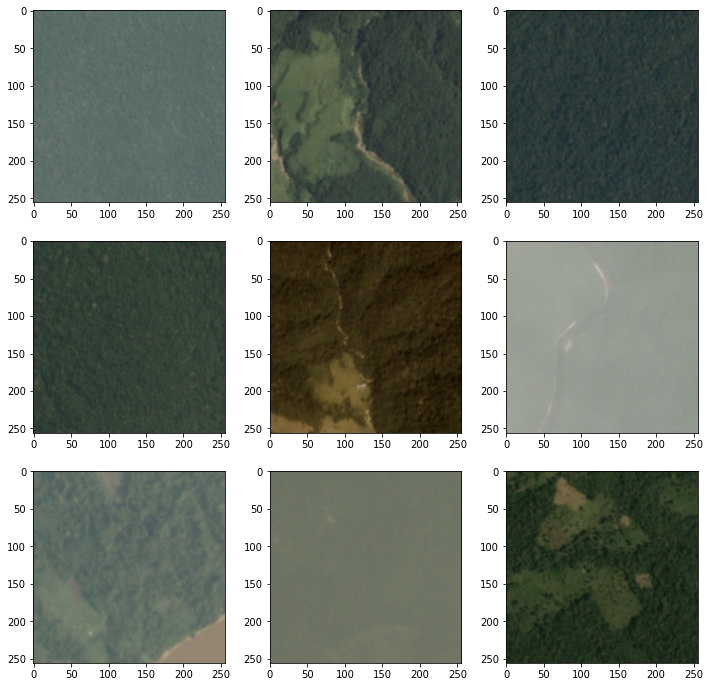

In [17]:
# Plot the first nine training images in the Planet dataset
train_folder = 'train-jpg/'
fig = plt.figure(figsize=(12,12))
for i in range(9):
	# define subplot
	plt.subplot(330 + 1 + i)
	# define filename
	filename = train_folder + 'train_' + str(i) + '.jpg'
	# load image pixels
	image = mpimg.imread(filename)
	# plot raw pixel data
	plt.imshow(image)
plt.show()

In [18]:
if notifyStatus: status_notify('(TensorFlow Multi-Label) Task 2 - Summarize and Visualize Data completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 3 - Pre-process Data

In [19]:
if notifyStatus: status_notify('(TensorFlow Multi-Label) Task 3 - Pre-process Data has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

## 3.a) Create Label Mappings

In [20]:
# Create a mapping of tags to integers given the loaded mapping file
def create_tag_mapping(mapping_csv):
	# create a set of all known tags
	labels = set()
	for i in range(len(mapping_csv)):
		# convert spaced separated tags into an array of tags
		tags = mapping_csv['tags'][i].split(' ')
		# add tags to the set of known labels
		labels.update(tags)
	# convert set of labels to a list to list
	labels = list(labels)
	# order set alphabetically
	labels.sort()
	# dict that maps labels to integers, and the reverse
	labels_map = {labels[i]:i for i in range(len(labels))}
	inv_labels_map = {i:labels[i] for i in range(len(labels))}
	return labels_map, inv_labels_map

# Load file as CSV
filename = 'https://dainesanalytics.com/datasets/kaggle-planet-understand-amazon/train_v2.csv'
mapping_csv = pd.read_csv(filename)

# Create a mapping of tags to integers
tag_mapping, inv_mapping = create_tag_mapping(mapping_csv)
print('Total number of tags found:', len(tag_mapping))
print(tag_mapping)
print(inv_mapping)

Total number of tags found: 17
{'agriculture': 0, 'artisinal_mine': 1, 'bare_ground': 2, 'blooming': 3, 'blow_down': 4, 'clear': 5, 'cloudy': 6, 'conventional_mine': 7, 'cultivation': 8, 'habitation': 9, 'haze': 10, 'partly_cloudy': 11, 'primary': 12, 'road': 13, 'selective_logging': 14, 'slash_burn': 15, 'water': 16}
{0: 'agriculture', 1: 'artisinal_mine', 2: 'bare_ground', 3: 'blooming', 4: 'blow_down', 5: 'clear', 6: 'cloudy', 7: 'conventional_mine', 8: 'cultivation', 9: 'habitation', 10: 'haze', 11: 'partly_cloudy', 12: 'primary', 13: 'road', 14: 'selective_logging', 15: 'slash_burn', 16: 'water'}


## 3.b) Create the In-Memory Dataset

In [21]:
# Create a mapping of filename to a list of tags
def create_file_mapping(mapping_csv):
	mapping = dict()
	for i in range(len(mapping_csv)):
		name, tags = mapping_csv['image_name'][i], mapping_csv['tags'][i]
		mapping[name] = tags.split(' ')
	return mapping

# Create a mapping of filenames to tag lists
file_mapping = create_file_mapping(mapping_csv)

idx = 0
print('Take a peak at the first few training samples...')
for key in file_mapping:
  idx = idx + 1
  if idx > 5: break
  print(key, file_mapping[key])

Take a peak at the first few training samples...
train_0 ['haze', 'primary']
train_1 ['agriculture', 'clear', 'primary', 'water']
train_2 ['clear', 'primary']
train_3 ['clear', 'primary']
train_4 ['agriculture', 'clear', 'habitation', 'primary', 'road']


In [22]:
# Create a one-hot encoding for one list of tags
def one_hot_encode(tags, mapping):
	# create empty vector
	encoding = np.zeros(len(mapping), dtype='uint8')
	# mark 1 for each tag in the vector
	for tag in tags:
		encoding[mapping[tag]] = 1
	return encoding

# Load all training images into memory
def load_dataset(path, file_mapping, tag_mapping):
	photos, targets = list(), list()
	# enumerate files in the directory
	for filename in os.listdir(path):
		# load image
		photo = load_img(path + filename, target_size=target_image_size)
		# convert to numpy array
		photo = img_to_array(photo, dtype='uint8')
		# get tags
		tags = file_mapping[filename[:-4]]
		# one hot encode tags
		target = one_hot_encode(tags, tag_mapping)
		# store
		photos.append(photo)
		targets.append(target)
	X = np.asarray(photos, dtype='uint8')
	y = np.asarray(targets, dtype='uint8')
	return X, y

# Load the jpeg images
X_complete, y_complete = load_dataset(train_folder, file_mapping, tag_mapping)
print("X_complete.shape: {} y_complete.shape: {}".format(X_complete.shape, y_complete.shape))

X_complete.shape: (40479, 128, 128, 3) y_complete.shape: (40479, 17)


In [23]:
# # Save both arrays to one file in compressed format for later retrieval
# np.savez_compressed('planet_data.npz', X_original, y_original)

In [24]:
# # load train and validation datasets from the compressed save file
# data = np.load('planet_data.npz')
# X_original, y_original = data['arr_0'], data['arr_1']

In [25]:
# Finalize the training and validation datasets for the modeling activities
X_train, X_validation, y_train, y_validation = train_test_split(X_complete, y_complete, test_size=val_set_size, random_state=seedNum)
print("X_train.shape: {} y_train.shape: {}".format(X_train.shape, y_train.shape))
print("X_validation.shape: {} y_validation.shape: {}".format(X_validation.shape, y_validation.shape))

X_train.shape: (30359, 128, 128, 3) y_train.shape: (30359, 17)
X_validation.shape: (10120, 128, 128, 3) y_validation.shape: (10120, 17)


In [26]:
print('Loading and pre-processing the training images...')
train_datagen = ImageDataGenerator(rescale=1.0/255.0)
train_generator = train_datagen.flow(X_train, y_train, batch_size=default_batch)
print('Number of image batches per epoch of modeling:', len(train_generator))

Loading and pre-processing the training images...
Number of image batches per epoch of modeling: 475


In [27]:
print('Loading and pre-processing the validation images...')
validation_datagen = ImageDataGenerator(rescale=1.0/255.0)
validation_generator = validation_datagen.flow(X_validation, y_validation, batch_size=default_batch)
print('Number of image batches per epoch of modeling:', len(validation_generator))

Loading and pre-processing the validation images...
Number of image batches per epoch of modeling: 159


In [28]:
if notifyStatus: status_notify('(TensorFlow Multi-Label) Task 3 - Pre-process Data completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 4. Evaluate and Optimize Model

In [29]:
if notifyStatus: status_notify('(TensorFlow Multi-Label) Task 4 - Train and Evaluate Models has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

### 4.a) Train and Validate Models

In [30]:
# Test the f-beta scoring facility
# Make all one predictions
yhat_train = np.asarray([np.ones(y_train.shape[1]) for _ in range(y_train.shape[0])])
yhat_validation = np.asarray([np.ones(y_validation.shape[1]) for _ in range(y_validation.shape[0])])

# Evaluate predictions with sklearn
score_train = fbeta_score(y_train, yhat_train, 2, average='samples')
score_validation = fbeta_score(y_validation, yhat_validation, 2, average='samples')
print('All Ones (sklearn): train=%.3f, validation=%.3f' % (score_train, score_validation))

All Ones (sklearn): train=0.484, validation=0.484


In [31]:
# calculate fbeta score for multi-class/label classification
def fbeta(y_true, y_pred, beta=2):
	# clip predictions
	y_pred = backend.clip(y_pred, 0, 1)
	# calculate elements
	tp = backend.sum(backend.round(backend.clip(y_true * y_pred, 0, 1)), axis=1)
	fp = backend.sum(backend.round(backend.clip(y_pred - y_true, 0, 1)), axis=1)
	fn = backend.sum(backend.round(backend.clip(y_true - y_pred, 0, 1)), axis=1)
	# calculate precision
	p = tp / (tp + fp + backend.epsilon())
	# calculate recall
	r = tp / (tp + fn + backend.epsilon())
	# calculate fbeta, averaged across each class
	bb = beta ** 2
	fbeta_score = backend.mean((1 + bb) * (p * r) / (bb * p + r + backend.epsilon()))
	return fbeta_score

# Evaluate predictions with keras
score_train = fbeta(backend.variable(y_train), backend.variable(yhat_train))
score_validation = fbeta(backend.variable(y_validation), backend.variable(yhat_validation))
print('All Ones (keras): train=%.3f, validation=%.3f' % (score_train, score_validation))

All Ones (keras): train=0.484, validation=0.484


In [32]:
# Define the function for plotting training results for comparison
def plot_metrics(history):
    fig, axs = plt.subplots(1, 2, figsize=(24, 15))
    metrics =  [train_loss, train_metric]
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric], color='blue', label='Train')
        plt.plot(history.epoch, history.history['val_'+metric], color='red', linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == train_loss:
            plt.ylim([0, plt.ylim()[1]])
        else:
            plt.ylim([0, 1])
        plt.legend()

In [33]:
# Define the baseline model for benchmarking
def create_nn_model(n_inputs=input_image_size, n_outputs=num_class, conv1_filters=32, conv2_filters=64, conv3_filters=128,
                    conv1_dropout=0, conv2_dropout=0, conv3_dropout=0, dense_nodes=128, dense_dropout=0,
                    opt_param=default_optimizer, init_param=default_kernel_init):
    nn_model = keras.Sequential([
        # This is the first convolution
        keras.layers.Conv2D(conv1_filters, (3,3), padding='same', activation='relu', kernel_initializer=init_param, input_shape=input_image_size),
        keras.layers.Conv2D(conv1_filters, (3,3), padding='same', activation='relu', kernel_initializer=init_param),
        keras.layers.MaxPooling2D(2,2),
        # keras.layers.Dropout(conv1_dropout),
        # This is the second convolution
        keras.layers.Conv2D(conv2_filters, (3,3), padding='same', activation='relu', kernel_initializer=init_param),
        keras.layers.Conv2D(conv2_filters, (3,3), padding='same', activation='relu', kernel_initializer=init_param),
        keras.layers.MaxPooling2D(2,2),
        # keras.layers.Dropout(conv2_dropout),
        # This is the third convolution
        keras.layers.Conv2D(conv3_filters, (3,3), padding='same', activation='relu', kernel_initializer=init_param),
        keras.layers.Conv2D(conv3_filters, (3,3), padding='same', activation='relu', kernel_initializer=init_param),
        keras.layers.MaxPooling2D(2,2),
        # keras.layers.Dropout(conv3_dropout),
        # Flatten the results to feed into a DNN
        keras.layers.Flatten(),
        keras.layers.Dense(dense_nodes, activation='relu', kernel_initializer=init_param),
        # keras.layers.Dropout(dense_dropout),
        keras.layers.Dense(num_class, activation='sigmoid', kernel_initializer=init_param)
    ])
    nn_model.compile(loss=default_loss, optimizer=opt_param, metrics=[fbeta])
    return nn_model

In [34]:
# Initialize the neural network model and get the training results for plotting graph
startTimeModule = datetime.now()
reset_random(seedNum)
nn_model_0 = create_nn_model()
nn_model_history = nn_model_0.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
	validation_data=validation_generator,
    validation_steps=len(validation_generator),
    epochs=default_epoch,
    verbose=1)
print('Total time for model fitting:', (datetime.now() - startTimeModule))

Epoch 1/10
475/475 [==============================] - 14s 28ms/step - loss: 0.2162 - fbeta: 0.6928 - val_loss: 0.1766 - val_fbeta: 0.7365
Epoch 2/10
475/475 [==============================] - 13s 28ms/step - loss: 0.1665 - fbeta: 0.7765 - val_loss: 0.1593 - val_fbeta: 0.7996
Epoch 3/10
475/475 [==============================] - 13s 28ms/step - loss: 0.1452 - fbeta: 0.8102 - val_loss: 0.1411 - val_fbeta: 0.8277
Epoch 4/10
475/475 [==============================] - 13s 28ms/step - loss: 0.1330 - fbeta: 0.8309 - val_loss: 0.1384 - val_fbeta: 0.8166
Epoch 5/10
475/475 [==============================] - 13s 28ms/step - loss: 0.1223 - fbeta: 0.8452 - val_loss: 0.1352 - val_fbeta: 0.8367
Epoch 6/10
475/475 [==============================] - 13s 28ms/step - loss: 0.1101 - fbeta: 0.8627 - val_loss: 0.1394 - val_fbeta: 0.8380
Epoch 7/10
475/475 [==============================] - 13s 28ms/step - loss: 0.0960 - fbeta: 0.8813 - val_loss: 0.1461 - val_fbeta: 0.8447
Epoch 8/10
475/475 [==============

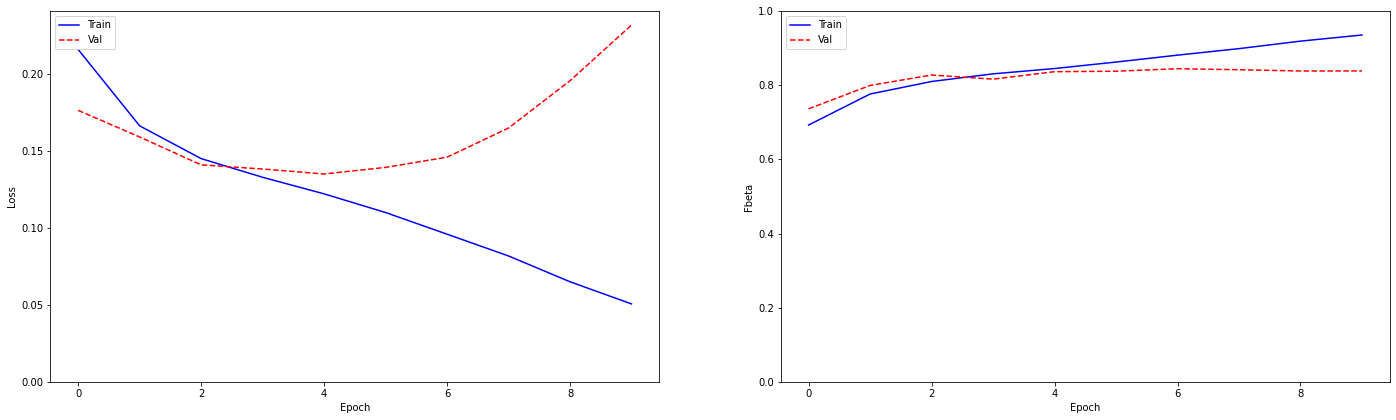

In [35]:
# learning curves
plot_metrics(nn_model_history)

### 4.b) Finalize the Model

In [36]:
print('Loading and pre-processing the training images...')
train_datagen = ImageDataGenerator(rescale=1.0/255.0)
train_generator = train_datagen.flow(X_complete, y_complete, batch_size=default_batch)
print('Number of image batches per epoch of modeling:', len(train_generator))

Loading and pre-processing the training images...
Number of image batches per epoch of modeling: 633


In [37]:
startTimeModule = datetime.now()
reset_random(seedNum)
final_model = create_nn_model()
final_model_history = nn_model_0.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=default_epoch,
    verbose=0)
print('Total time for fitting the final model:', (datetime.now() - startTimeModule))

Total time for fitting the final model: 0:02:16.766860


In [38]:
# Display a summary of the final model
final_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 128, 128, 32)      896       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 128, 128, 32)      9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 32, 32, 128)      

In [39]:
if notifyStatus: status_notify('(TensorFlow Multi-Label) Task 4 - Train and Evaluate Models completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 5 - Finalize Model and Present Analysis

In [40]:
if notifyStatus: status_notify('(TensorFlow Multi-Label) Task 5 - Finalize Model and Present Analysis has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [41]:
# Not applicable for this iteration of modeling

In [42]:
!wget --no-clobber https://dainesanalytics.com/datasets/kaggle-planet-understand-amazon/test-jpg.tar.7z

--2020-11-01 01:57:13--  https://dainesanalytics.com/datasets/kaggle-planet-understand-amazon/test-jpg.tar.7z
Resolving dainesanalytics.com (dainesanalytics.com)... 13.227.209.36, 13.227.209.71, 13.227.209.85, ...
Connecting to dainesanalytics.com (dainesanalytics.com)|13.227.209.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 632362315 (603M) [application/x-7z-compressed]
Saving to: ‘test-jpg.tar.7z’

test-jpg.tar.7z     100%[===================>] 603.07M  90.6MB/s    in 6.6s    

2020-11-01 01:57:20 (91.0 MB/s) - ‘test-jpg.tar.7z’ saved [632362315/632362315]



In [43]:
!7z x test-jpg.tar.7z
!tar -xf test-jpg.tar


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,4 CPUs Intel(R) Xeon(R) CPU @ 2.00GHz (50653),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 632362315 bytes (604 MiB)

Extracting archive: test-jpg.tar.7z
--
Path = test-jpg.tar.7z
Type = 7z
Physical Size = 632362315
Headers Size = 98
Method = LZMA2:24
Solid = -
Blocks = 1

  0%      0% - test-jpg.tar                     1% - test-jpg.tar                     2% - test-jpg.tar                     3% - test-jpg.tar                     4% - test-jpg.tar                     5% - test-jpg.tar                     6% - test-jpg.tar                   

In [44]:
!wget --no-clobber https://dainesanalytics.com/datasets/kaggle-planet-understand-amazon/test-jpg-additional.tar.7z

--2020-11-01 01:58:09--  https://dainesanalytics.com/datasets/kaggle-planet-understand-amazon/test-jpg-additional.tar.7z
Resolving dainesanalytics.com (dainesanalytics.com)... 13.227.209.61, 13.227.209.36, 13.227.209.85, ...
Connecting to dainesanalytics.com (dainesanalytics.com)|13.227.209.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 318407195 (304M) [application/x-7z-compressed]
Saving to: ‘test-jpg-additional.tar.7z’

test-jpg-additional 100%[===================>] 303.66M  88.3MB/s    in 3.5s    

2020-11-01 01:58:12 (87.9 MB/s) - ‘test-jpg-additional.tar.7z’ saved [318407195/318407195]



In [45]:
!7z x test-jpg-additional.tar.7z
!tar -xf test-jpg-additional.tar
!cp test-jpg-additional/*.* test-jpg/


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,4 CPUs Intel(R) Xeon(R) CPU @ 2.00GHz (50653),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 318407195 bytes (304 MiB)

Extracting archive: test-jpg-additional.tar.7z
--
Path = test-jpg-additional.tar.7z
Type = 7z
Physical Size = 318407195
Headers Size = 98
Method = LZMA2:24
Solid = -
Blocks = 1

  0%      0% - test-jpg-additional.tar                                2% - test-jpg-additional.tar                                3% - test-jpg-additional.tar                                4% - test-jpg-additional.tar                                5% - test-jpg-addition

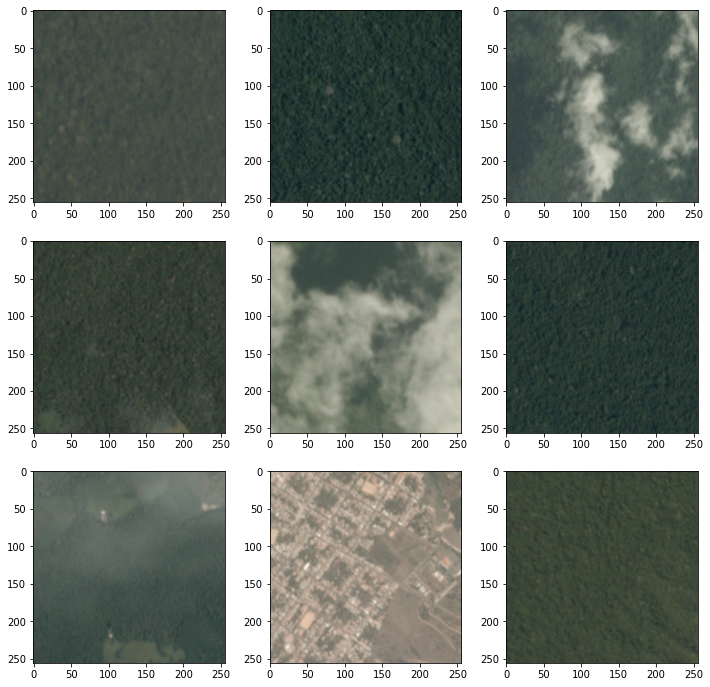

In [46]:
# Plot the first nine training images in the Planet dataset
test_folder = 'test-jpg/'
fig = plt.figure(figsize=(12,12))
for i in range(9):
	# define subplot
	plt.subplot(330 + 1 + i)
	# define filename
	filename = test_folder + 'test_' + str(i) + '.jpg'
	# load image pixels
	image = mpimg.imread(filename)
	# plot raw pixel data
	plt.imshow(image)
plt.show()

In [47]:
# Convert a prediction to tags
def prediction_to_tags(mapping, prediction):
	# round probabilities to {0, 1}
	values = prediction.round()
	# collect all predicted tags
	tags = [mapping[i] for i in range(len(values)) if values[i] == 1.0]
	return tags

In [48]:
# load and prepare the image
def load_image(filename):
	# load the image
	img = load_img(filename, target_size=target_image_size)
	# convert to array
	img = img_to_array(img)
	# reshape into a single sample with 3 channels
	img = img.reshape(1, 128, 128, 3)
	# center pixel data
	img = img.astype('float32')
	img = img - [123.68, 116.779, 103.939]
	return img

In [49]:
# Load an image and predict the class
def predict_image(test_img, mapping):
	# load the image
	img = load_image(test_img)
	# predict the class
	result = final_model.predict(img)
	# print(result[0])
	# map prediction to tags
	tags = prediction_to_tags(mapping, result[0])
	# print(tags)
	# print()
	sep = ' '
	tag_string = sep.join(tags)
	return tag_string

In [50]:
dataset_path = 'https://dainesanalytics.com/datasets/kaggle-planet-understand-amazon/sample_submission_v2.csv'
X_kaggle_data = pd.read_csv(dataset_path, sep=',', index_col=False)

# Take a peek at the dataframe after import
print(X_kaggle_data.head())

  image_name                                  tags
0     test_0  primary clear agriculture road water
1     test_1  primary clear agriculture road water
2     test_2  primary clear agriculture road water
3     test_3  primary clear agriculture road water
4     test_4  primary clear agriculture road water


In [51]:
# Predict the test images
for i in range(len(X_kaggle_data)):
    test_image = test_folder + X_kaggle_data.iloc[i]['image_name'] + '.jpg'
    prediction = predict_image(test_image, inv_mapping)
    X_kaggle_data.iloc[i]['tags'] = prediction
    if ((i+1) % 1000) == 0 : print('Number of images processed so far:', i+1)
print('Total number of images processed:', i+1)

Number of images processed so far: 1000
Number of images processed so far: 2000
Number of images processed so far: 3000
Number of images processed so far: 4000
Number of images processed so far: 5000
Number of images processed so far: 6000
Number of images processed so far: 7000
Number of images processed so far: 8000
Number of images processed so far: 9000
Number of images processed so far: 10000
Number of images processed so far: 11000
Number of images processed so far: 12000
Number of images processed so far: 13000
Number of images processed so far: 14000
Number of images processed so far: 15000
Number of images processed so far: 16000
Number of images processed so far: 17000
Number of images processed so far: 18000
Number of images processed so far: 19000
Number of images processed so far: 20000
Number of images processed so far: 21000
Number of images processed so far: 22000
Number of images processed so far: 23000
Number of images processed so far: 24000
Number of images processe

In [52]:
submission_file = X_kaggle_data.to_csv(header=True, index=False)
filename = 'submission_' + datetime.now().strftime('%Y%m%d-%H%M') + '.csv'
with open(filename, 'w') as f:
    f.write(submission_file)
    print('Completed writing output file: ' + filename)

Completed writing output file: submission_20201101-0235.csv


In [53]:
if notifyStatus: status_notify('(TensorFlow Multi-Label) Task 5 - Finalize Model and Present Analysis completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [54]:
print ('Total time for the script:',(datetime.now() - startTimeScript))

Total time for the script: 0:45:16.159816
